# Pion Classification with 1D CNN

Binary classifier to identify charged pions ($\pi^{\pm}$, label 2) from ProtoDUNE hit-level data using a 1D CNN with masked pooling.

In [37]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from nn_utils import purity, efficiency, create_confusion_matrix, load_file

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: mps


## Data Loading

`DATASET_SIZE` options:
- `"1000"`
- `"10000"`
- `"100000"`
- `"FULL" (~650,000)`

In [38]:
DATASET_SIZE = "100000"
DATA_DIR = "extracted-data-hit"
PION_LABEL = 2

data = load_file(f"{DATA_DIR}/data_{DATASET_SIZE}_split.pkl")
x_train_raw = data['x_train']
x_test_raw = data['x_test']
y_train_raw = data['y_train']
y_test_raw = data['y_test']
le = data['le']

print(f"Label encoder classes: {le.classes_}")
print(f"x_train: {x_train_raw.shape}, x_test: {x_test_raw.shape}")

# Convert to binary: 1 = pion, 0 = not pion
y_train_binary = (y_train_raw == PION_LABEL).astype(np.int64)
y_test_binary = (y_test_raw == PION_LABEL).astype(np.int64)

n_pion_train = y_train_binary.sum()
n_pion_test = y_test_binary.sum()
print(f"\nTrain: {n_pion_train} pions / {len(y_train_binary)} total ({100*n_pion_train/len(y_train_binary):.1f}%)")
print(f"Test:  {n_pion_test} pions / {len(y_test_binary)} total ({100*n_pion_test/len(y_test_binary):.1f}%)")

Label encoder classes: ['$\\gamma$' '$\\mu^{\\pm}$' '$\\pi^{\\pm}$' '$\\pi^{\\pm}$:2nd' '$e^{+}$'
 '$p$' 'other']
x_train: (34123, 120, 2), x_test: (8531, 120, 2)

Train: 6105 pions / 34123 total (17.9%)
Test:  1555 pions / 8531 total (18.2%)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.1.3 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Preprocessing

Clip outliers, then z-score normalize using training stats only. Padding stays at 0.

In [39]:
DEDX_CLIP = 50.0
RR_CLIP = 150.0

def preprocess(x_train, x_test):
    """Clip outliers, z-score normalize, preserve padding as 0."""
    x_train = x_train.copy()
    x_test = x_test.copy()

    # Compute masks before any modification
    train_mask = np.any(x_train != 0, axis=2)  # (N, 120)
    test_mask = np.any(x_test != 0, axis=2)

    # Clip outliers (only non-padded entries)
    for x, mask in [(x_train, train_mask), (x_test, test_mask)]:
        x[:, :, 0] = np.where(mask, np.clip(x[:, :, 0], 0, DEDX_CLIP), 0)
        x[:, :, 1] = np.where(mask, np.clip(x[:, :, 1], 0, RR_CLIP), 0)

    # Compute stats from training data only
    train_hits = x_train[train_mask]  # (total_real_hits, 2)
    feat_mean = train_hits.mean(axis=0)
    feat_std = train_hits.std(axis=0)
    print(f"Feature means: dEdX={feat_mean[0]:.3f}, RR={feat_mean[1]:.3f}")
    print(f"Feature stds:  dEdX={feat_std[0]:.3f}, RR={feat_std[1]:.3f}")

    # Normalize, keeping padding at 0
    x_train_norm = np.where(train_mask[:, :, np.newaxis], (x_train - feat_mean) / feat_std, 0.0)
    x_test_norm = np.where(test_mask[:, :, np.newaxis], (x_test - feat_mean) / feat_std, 0.0)

    return x_train_norm.astype(np.float32), x_test_norm.astype(np.float32), train_mask, test_mask

x_train_norm, x_test_norm, train_mask, test_mask = preprocess(x_train_raw, x_test_raw)

# Track length statistics
lengths = train_mask.sum(axis=1)
print(f"\nTrack lengths — mean: {lengths.mean():.1f}, median: {np.median(lengths):.0f}, "
      f"min: {lengths.min()}, max: {lengths.max()}")

Feature means: dEdX=3.467, RR=33.566
Feature stds:  dEdX=3.870, RR=31.332

Track lengths — mean: 36.9, median: 23, min: 2, max: 120


## PyTorch Dataset & DataLoader

In [40]:
class PionDataset(Dataset):
    def __init__(self, x, y, mask):
        # x: (N, 120, 2) -> (N, 2, 120) for Conv1d
        self.x = torch.FloatTensor(x).permute(0, 2, 1)
        self.y = torch.LongTensor(y)
        self.mask = torch.FloatTensor(mask.astype(np.float32))

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.mask[idx], self.y[idx]


train_dataset = PionDataset(x_train_norm, y_train_binary, train_mask)
test_dataset = PionDataset(x_test_norm, y_test_binary, test_mask)

# Weighted sampler to balance classes during training
class_counts = np.bincount(y_train_binary)
sample_weights = (1.0 / class_counts)[y_train_binary]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Train batches: 267, Test batches: 67


## Model Definition

In [43]:
class MaskedGlobalAvgPool1d(nn.Module):
    """Average pooling that ignores zero-padded positions."""
    def forward(self, x, mask):
        # x: (B, C, L), mask: (B, L)
        mask_exp = mask.unsqueeze(1)  # (B, 1, L)
        x_masked = x * mask_exp
        lengths = mask_exp.sum(dim=2, keepdim=True).clamp(min=1)  # (B, 1, 1)
        return (x_masked.sum(dim=2) / lengths.squeeze(2))  # (B, C)


class FocalLoss(nn.Module):
    """Down-weights easy examples so the model focuses on hard cases."""
    def __init__(self, alpha=1.0, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce)  # probability of correct class
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()


class PionCNN(nn.Module):
    def __init__(self, in_channels=2, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(64)

        self.pool = MaskedGlobalAvgPool1d()
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x, mask):
        # x: (B, 2, 120), mask: (B, 120)
        x = x * mask.unsqueeze(1)  # zero out padding
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x, mask)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(1)


model = PionCNN(dropout=0.3).to(device)
print(model)
print(f"\nParameters: {sum(p.numel() for p in model.parameters()):,}")

PionCNN(
  (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaskedGlobalAvgPool1d()
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

Parameters: 41,697


## Training

In [44]:
criterion = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    n_samples = 0
    for x, mask, y in loader:
        x, mask, y = x.to(device), mask.to(device), y.float().to(device)
        optimizer.zero_grad()
        loss = criterion(model(x, mask), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y)
        n_samples += len(y)
    return total_loss / n_samples


def evaluate(model, loader, criterion, threshold=0.5):
    model.eval()
    total_loss = 0
    n_samples = 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, mask, y in loader:
            x, mask, y = x.to(device), mask.to(device), y.float().to(device)
            logits = model(x, mask)
            total_loss += criterion(logits, y).item() * len(y)
            n_samples += len(y)
            all_probs.extend(torch.sigmoid(logits).cpu().numpy())
            all_labels.extend(y.cpu().numpy().astype(int))

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_preds = (all_probs >= threshold).astype(int)

    pur = purity(all_preds, all_labels, [1], [1])
    eff = efficiency(all_preds, all_labels, [1], [1])

    return total_loss / n_samples, pur, eff, all_probs, all_labels


N_EPOCHS = 80
EARLY_STOP_PATIENCE = 15

best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
history = {'train_loss': [], 'val_loss': [], 'purity': [], 'efficiency': []}

for epoch in range(N_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, pur, eff, _, _ = evaluate(model, test_loader, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['purity'].append(pur)
    history['efficiency'].append(eff)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
              f"Purity: {100*pur:.1f}% | Efficiency: {100*eff:.1f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_state)
print(f"\nBest validation loss: {best_val_loss:.4f}")

Epoch   1 | Train: 0.1367 | Val: 0.1299 | Purity: 40.0% | Efficiency: 75.2%
Epoch   5 | Train: 0.1184 | Val: 0.1583 | Purity: 32.3% | Efficiency: 88.5%
Epoch  10 | Train: 0.1148 | Val: 0.1159 | Purity: 46.4% | Efficiency: 75.3%
Epoch  15 | Train: 0.1122 | Val: 0.1289 | Purity: 41.7% | Efficiency: 79.3%
Epoch  20 | Train: 0.1063 | Val: 0.1178 | Purity: 44.5% | Efficiency: 80.5%
Epoch  25 | Train: 0.1051 | Val: 0.1099 | Purity: 47.9% | Efficiency: 77.3%
Epoch  30 | Train: 0.0993 | Val: 0.1100 | Purity: 48.1% | Efficiency: 76.9%
Epoch  35 | Train: 0.0959 | Val: 0.1125 | Purity: 46.8% | Efficiency: 78.9%
Early stopping at epoch 37

Best validation loss: 0.1035


## Training Curves

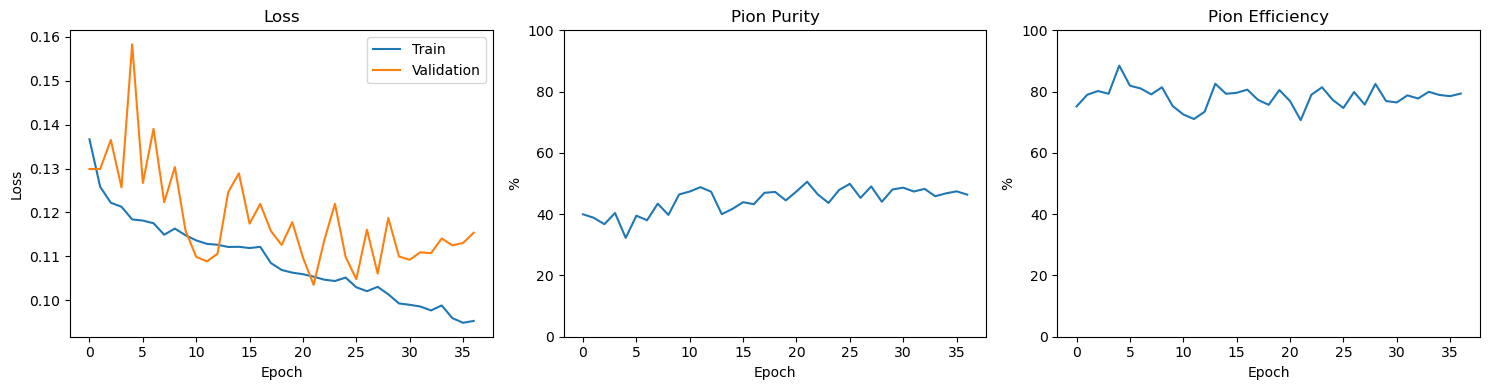

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot([100*p for p in history['purity']])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('%')
axes[1].set_title('Pion Purity')
axes[1].set_ylim([0, 100])

axes[2].plot([100*e for e in history['efficiency']])
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('%')
axes[2].set_title('Pion Efficiency')
axes[2].set_ylim([0, 100])

plt.tight_layout()
plt.show()

## Threshold Optimisation

The default threshold of 0.5 is rarely optimal for imbalanced problems. Scan thresholds to find the operating point that maximises purity $\times$ efficiency.

Optimal threshold (max purity x efficiency): 0.55
  Purity:     55.8%
  Efficiency: 65.1%
  Product:    36.3%


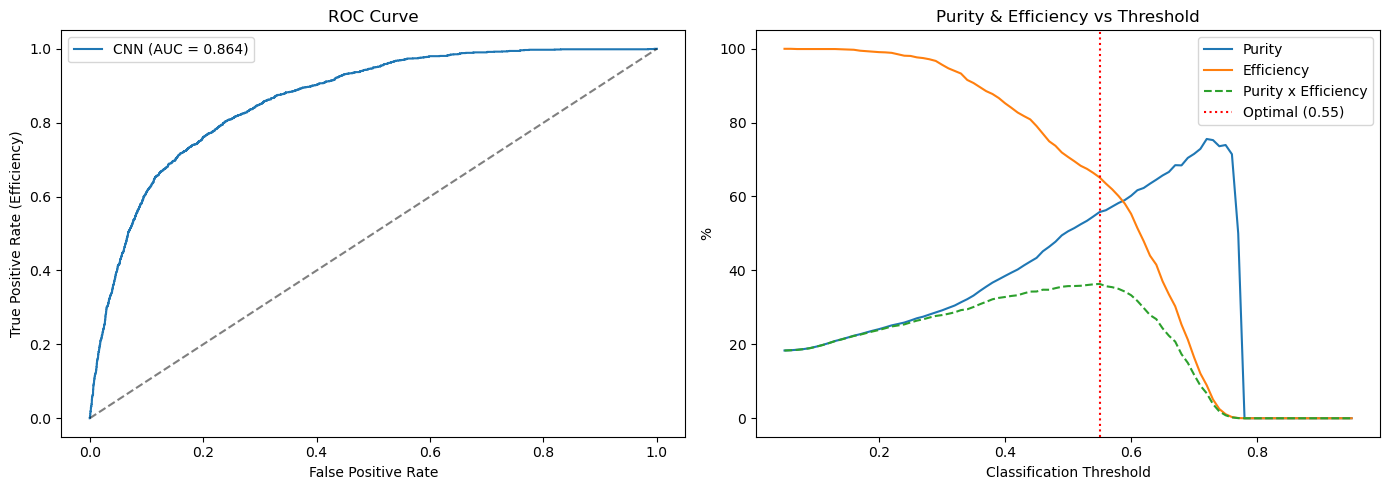

In [46]:
_, _, _, test_probs, test_labels = evaluate(model, test_loader, criterion)

# ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

# Threshold scan
thresholds = np.arange(0.05, 0.96, 0.01)
purities_scan = []
efficiencies_scan = []

for t in thresholds:
    preds = (test_probs >= t).astype(int)
    purities_scan.append(purity(preds, test_labels, [1], [1]))
    efficiencies_scan.append(efficiency(preds, test_labels, [1], [1]))

purities_scan = np.array(purities_scan)
efficiencies_scan = np.array(efficiencies_scan)
product = purities_scan * efficiencies_scan

best_idx = np.argmax(product)
best_threshold = thresholds[best_idx]

print(f"Optimal threshold (max purity x efficiency): {best_threshold:.2f}")
print(f"  Purity:     {100*purities_scan[best_idx]:.1f}%")
print(f"  Efficiency: {100*efficiencies_scan[best_idx]:.1f}%")
print(f"  Product:    {100*product[best_idx]:.1f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr, tpr, label=f'CNN (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate (Efficiency)')
axes[0].set_title('ROC Curve')
axes[0].legend()

axes[1].plot(thresholds, 100*purities_scan, label='Purity')
axes[1].plot(thresholds, 100*efficiencies_scan, label='Efficiency')
axes[1].plot(thresholds, 100*product, '--', label='Purity x Efficiency')
axes[1].axvline(best_threshold, color='red', ls=':', label=f'Optimal ({best_threshold:.2f})')
axes[1].set_xlabel('Classification Threshold')
axes[1].set_ylabel('%')
axes[1].set_title('Purity & Efficiency vs Threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

## Final Evaluation

In [9]:
THRESHOLD = best_threshold

final_preds = (test_probs >= THRESHOLD).astype(int)

pur_val, pur_unc = purity(final_preds, test_labels, [1], [1], return_uncertainty=True)
eff_val, eff_unc = efficiency(final_preds, test_labels, [1], [1], return_uncertainty=True)

print(f"=== Final Results (threshold={THRESHOLD:.2f}) ===")
print(f"Pion Purity:     {100*pur_val:.1f}% ± {100*pur_unc:.1f}%")
print(f"Pion Efficiency: {100*eff_val:.1f}% ± {100*eff_unc:.1f}%")
print(f"Purity x Eff:    {100*pur_val*eff_val:.1f}%")
print(f"ROC AUC:         {roc_auc:.3f}")

=== Final Results (threshold=0.48) ===
Pion Purity:     49.2% ± 1.0%
Pion Efficiency: 76.3% ± 1.1%
Purity x Eff:    37.6%
ROC AUC:         0.873


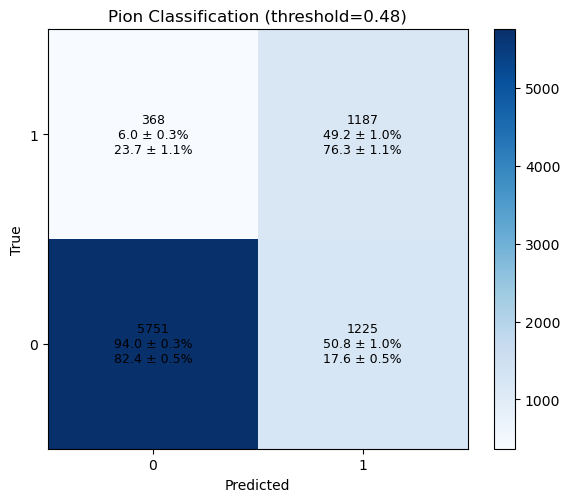

In [28]:
# Confusion matrix
label_names = ['Non-pion', 'Pion']
cm, info, labels = create_confusion_matrix(test_labels, final_preds)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, info[i][j], ha='center', va='center', fontsize=9)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels[::-1])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'Pion Classification (threshold={THRESHOLD:.2f})')
plt.colorbar(im)
plt.tight_layout()
plt.show()

In [47]:
# Save results for model comparison
results = {
    "model_name": "CNN (hit-level dEdX + RR)",
    "probs": test_probs,
    "labels": test_labels,
    "threshold": best_threshold,
    "purity": pur_val,
    "efficiency": eff_val,
    "auc": roc_auc
}

import os
os.makedirs("results", exist_ok=True)

with open("results/cnn_hit_level.pkl", "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to results/cnn_hit_level.pkl")
print(f"Keys: {list(results.keys())}")

Results saved to results/cnn_hit_level.pkl
Keys: ['model_name', 'probs', 'labels', 'threshold', 'purity', 'efficiency', 'auc']
